# Лаб-4. Рекомендации для коротких сессий

In [17]:
import torch
from torch import nn

import pandas as pd
import numpy as np
import datetime

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cpu


В качестве датасета будем использовать архив из мудла.

Это немного предобработанная версия [eCommerce events history](https://www.kaggle.com/datasets/mkechinov/ecommerce-events-history-in-electronics-store)

In [19]:
# Как и в предыдущей лабораторной пишем собственный загрузчик датасета
class ECommerceDataset:
    def __init__(self, path):
        self.train_data = pd.read_csv(rf"{path}/train_data.csv")
        self.test_data = pd.read_csv(rf"{path}/test_data.csv")

        # Добавляем колонку с идентификаторами товаров (для эмбедингов)
        all_data = pd.concat([self.train_data, self.test_data])
        unique_items = all_data['product_id'].unique()
        item_to_idx = pd.Series(data=np.arange(len(unique_items)), index=unique_items)
        item_map = pd.DataFrame({'product_id': unique_items, 'product_index': item_to_idx[unique_items].values})
        self.train_data = pd.merge(self.train_data, item_map, on='product_id', how='inner')
        self.test_data  = pd.merge(self.test_data,  item_map, on='product_id', how='inner')

        # Сортируем датасет так, чтобы все сессии оказались рядом, а клики внутри сессии упорядочились по времени
        self.train_data.sort_values(['user_session', 'event_time'], inplace=True)
        self.test_data.sort_values(['user_session', 'event_time'], inplace=True)

# Загрузка большого датасета может занять некоторое время
dataset = ECommerceDataset('dataset')

In [20]:
dataset.train_data

,event_time,product_id,user_session,product_index
32678,1604329884,80548,003pEktS1X,4865
34407,1607580196,630753,00ImhDtWxv,4292
21963,1607165660,387956,00xjwy5Rb6,8
31665,1607168978,387956,00xjwy5Rb6,8
23220,1611391773,738,00zEpCxZUK,1478
...,...,...,...,...
14766,1613148682,93765,zzaAzAFcYL,3193
15086,1613148695,93765,zzaAzAFcYL,3193
32226,1613408761,564777,zzveLpjyyb,1226
25067,1613409009,564777,zzveLpjyyb,1226


In [21]:
print(
    'Количество уникальных товаров',
    pd.concat([dataset.train_data, dataset.test_data])['product_id'].nunique(),
    '=',
    pd.concat([dataset.train_data, dataset.test_data])['product_index'].max() + 1
)

Количество уникальных товаров 15316 = 15316


За основу мы возьмём модель GRU4Rec из статьи

https://arxiv.org/pdf/1511.06939

Для обучения сети последовательными действиями пользователей, необходимо сконструировать минибатчи особым образом

![Формирование минибатчей](images/mini-batch-creation.png)

Так чтобы в инпуте батча содержался набор кликов пользователя, а в таргете набор следующих кликов из той же сессии

In [22]:
class ECommerceLoader():
    def __init__(self, data, batch_size, shuffle=False):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.session_count = data['user_session'].nunique()

        # Делаем массив с индексами начала и конца каждой сессии
        session_sizes = np.array(data.groupby('user_session').size().cumsum())
        self.offsets = np.append([0], session_sizes)

    def __iter__(self):
        session_order = np.arange(self.session_count)
        if self.shuffle:
            np.random.shuffle(session_order)

        # Заводим список активных сессий, размером с батч
        active_sessions = np.arange(self.batch_size)
        next_session = self.batch_size # индекс следующей сессии
        start = self.offsets[session_order[active_sessions]]   # индексы начал активных сессий
        end = self.offsets[session_order[active_sessions] + 1] # индексы концов активных сессий

        closed_mask = list(active_sessions) # список сессий, которые открываются на текущей итерации
        while True:
            min_len = (end - start).min() # Количество итераций, которые мы можем пройти, пока не закончится какая-то сессия
            idx_target = self.data['product_index'].values[start]

            # Итерируем по сессиям до тех пор, пока какая-то не закончится
            for i in range(min_len - 1):
                idx_input = idx_target
                idx_target = self.data['product_index'].values[start + i + 1]
                input = torch.LongTensor(idx_input)
                target = torch.LongTensor(idx_target)
                yield input, target, closed_mask # маску мы будем использовать чтобы обнулять новые сессии
                closed_mask = []

            start = start + (min_len - 1)

            # Пробегаемся по сессиям, которые должны быть завершены
            closed_mask = np.arange(len(active_sessions))[(end - start) <= 1]
            for idx in closed_mask:
                # Если новых сессий нет, просто завершаемся
                if next_session >= len(self.offsets) - 1:
                    return
                # Обновляем значения для новой сессии
                active_sessions[idx] = next_session
                start[idx] = self.offsets[session_order[next_session]]
                end[idx]   = self.offsets[session_order[next_session] + 1]
                next_session += 1

batch_size = 10

train_loader = ECommerceLoader(dataset.train_data, batch_size, shuffle=True)
test_loader  = ECommerceLoader(dataset.test_data, batch_size)

Сама модель основана на рекуррентной архитектуре, такие сети помимо выходного состояния возвращают ещё и скрытое состояние, которое передаётся в сеть на следующей итерации, позволяя таким образом обрабатывать связанные последовательности данных (такие как текст или действия пользователя).

![рекуррентная сеть](images/Recurrent_neural_network_unfold.svg.png)

В данном случае используется архитектура GRU (это как LSTM, но ещё лучше)
![](images/lstm-gru.png)


In [23]:
class GRU4Rec(nn.Module):
    def __init__(self):
        super().__init__()

        embedding_size = 64
        hidden_size = 64
        item_size = 15316

        # будем хранить внутреннее состояние внутри модели
        self.state = torch.zeros([batch_size, hidden_size])

        self.embedding = nn.Embedding(item_size, embedding_size)
        self.flatten = nn.Flatten()
        self.gru = nn.GRUCell(embedding_size, hidden_size)
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, item_size)
        )

    # Перегрузка to чтобы состояние тоже перевести на девайс
    def to(self, device):
        self.state = self.state.to(device)
        return super().to(device)

    # Обнуляем состояние для новых сессий
    def update_state(self, mask):
        self.state = self.state.detach()
        self.state[mask, :] = 0

    def forward(self, input):
        v = input.unsqueeze(1)
        v = self.embedding(v)
        v = self.flatten(v)
        v = self.state = self.gru(v, self.state)
        v = self.output_layer(v)
        return v


In [24]:
# Тренировка происходит и тестирование

def train_iteration(model, data_loader, loss_function, optimizer):
    model.train()

    for batch, (x, y, m) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        # Не забываем обнулить состояние
        model.update_state(m)

        pred = model(x)
        loss = loss_function(pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        if batch % 1000 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}]")

def test(model, data_loader, loss_function):
    model.eval()

    loss, correct, count = 0, 0 ,0
    with torch.no_grad():
        for x, y, m in data_loader:
            count += 1
            x, y = x.to(device), y.to(device)
            model.update_state(m)
            pred = model(x)
            loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss = loss / count
    correct /= count * batch_size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {loss:>8f} \n")
    pass


def train(epochs, model, loss_function, optimizer):
    for t in range(epochs):
        print(f"== Epoch {t + 1} ==")
        train_iteration(model, train_loader, loss_function, optimizer)
        test(model, test_loader, loss_function)

In [25]:
model = GRU4Rec().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(10, model, loss, optimizer)

== Epoch 1 ==
loss: 9.656355  [   10]
loss: 6.231440  [10010]
Test Error: 
 Accuracy: 3.0%, Avg loss: 10.260767 

== Epoch 2 ==
loss: 4.591116  [   10]
loss: 5.125344  [10010]
Test Error: 
 Accuracy: 3.6%, Avg loss: 11.827555 

== Epoch 3 ==
loss: 4.662642  [   10]
loss: 2.723526  [10010]
Test Error: 
 Accuracy: 3.8%, Avg loss: 12.514454 

== Epoch 4 ==
loss: 1.062050  [   10]
loss: 1.726875  [10010]
Test Error: 
 Accuracy: 3.9%, Avg loss: 13.110368 

== Epoch 5 ==
loss: 1.940707  [   10]
loss: 2.429151  [10010]
Test Error: 
 Accuracy: 4.0%, Avg loss: 13.724052 

== Epoch 6 ==
loss: 1.625784  [   10]
loss: 1.386835  [10010]
Test Error: 
 Accuracy: 4.0%, Avg loss: 14.242204 

== Epoch 7 ==
loss: 1.276568  [   10]
loss: 1.346617  [10010]
Test Error: 
 Accuracy: 4.0%, Avg loss: 14.748745 

== Epoch 8 ==
loss: 2.147127  [   10]
loss: 1.756533  [10010]
Test Error: 
 Accuracy: 4.0%, Avg loss: 15.314804 

== Epoch 9 ==
loss: 2.201849  [   10]
loss: 0.984723  [10010]
Test Error: 
 Accuracy: 4.

## Задания

Основные:
- Достичь точности в 3.5% на этом датасете - 5 баллов
- На основе GRU4Rec построить модель для датасета из предыдущей лабораторной (Movielens) - 5 баллов

Дополнительные задания:
- Реализовать одну из функций потерь BPR или TOP1 (https://arxiv.org/pdf/1511.06939) - 5 баллов
- Реализовать вторую функцию потерь - 5 баллов


## Полезные ссылки

Полезные ссылки по рекомендательным системам, модели из лекции и не только

- Репозиторий с кучей информации по рекомендательным системам https://github.com/recommenders-team/recommenders
- Рекомендательные системы на основе свёрток https://arxiv.org/pdf/1809.07426
- Sequence-Aware Factorization Machines (машина факторизации для временных последовательностей) https://arxiv.org/pdf/1911.02752



## Задание 1

In [26]:
model = GRU4Rec().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(10, model, loss, optimizer)

== Epoch 1 ==
loss: 9.630632  [   10]
loss: 5.763299  [10010]
Test Error: 
 Accuracy: 2.9%, Avg loss: 10.326396 

== Epoch 2 ==
loss: 3.432747  [   10]
loss: 2.312885  [10010]
Test Error: 
 Accuracy: 3.7%, Avg loss: 11.681224 

== Epoch 3 ==
loss: 2.200482  [   10]
loss: 2.423786  [10010]
Test Error: 
 Accuracy: 3.8%, Avg loss: 12.430148 

== Epoch 4 ==
loss: 2.055190  [   10]
loss: 1.359765  [10010]
Test Error: 
 Accuracy: 3.9%, Avg loss: 13.156513 

== Epoch 5 ==
loss: 4.909894  [   10]
loss: 2.419500  [10010]
Test Error: 
 Accuracy: 4.0%, Avg loss: 13.654528 

== Epoch 6 ==
loss: 1.307552  [   10]
loss: 1.179258  [10010]
Test Error: 
 Accuracy: 4.1%, Avg loss: 14.108481 

== Epoch 7 ==
loss: 1.509754  [   10]
loss: 1.716797  [10010]
Test Error: 
 Accuracy: 4.1%, Avg loss: 14.639094 

== Epoch 8 ==
loss: 0.685894  [   10]
loss: 0.812710  [10010]
Test Error: 
 Accuracy: 4.0%, Avg loss: 15.245944 

== Epoch 9 ==
loss: 1.872723  [   10]
loss: 0.562965  [10010]
Test Error: 
 Accuracy: 4.

## Задание 2

In [29]:
from torch.nn.utils.rnn import pad_sequence
import torch

from torch.utils.data import Dataset 

class MovielensDataset(Dataset):
    r"""seed должен быть одинаковым для обучающей и тренировочной выборки"""
    def __init__(self, source, train=True, seed=1, max_seq_len=50):
        ratings = pd.read_csv(rf"{source}\ratings.csv")
        self.movies = pd.read_csv(rf"{source}\movies.csv")

        # Преобразовываем Id фильмов в индексы в таблице movies
        x = self.movies.loc[:,['movieId']]
        x['movieId'], x.index = x.index, x['movieId'].values
        ratings['movieId'] = ratings['movieId'].map(x.to_dict()['movieId'])

        # делим датасет 80% на 20%
        train_data = ratings.sample(frac=0.8, random_state=seed)
        test_data  = ratings.drop(train_data.index)

        self.ratings = train_data if train else test_data
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        sample = self.ratings.iloc[idx]
        user_id = sample['userId']
        movie_id = sample['movieId']
        rating = sample['rating']
        
        # Создаем последовательность для каждого пользователя
        user_ratings = self.ratings[self.ratings['userId'] == user_id]
        sequence = user_ratings.sort_values(by='timestamp')['movieId'].values

        # Обрезаем или дополняем последовательность до max_seq_len
        sequence = sequence[-self.max_seq_len:]  # Оставляем последние max_seq_len фильмов
        sequence = torch.LongTensor(sequence)
        
        # Добавляем паддинг (если последовательность меньше max_seq_len)
        if len(sequence) < self.max_seq_len:
            sequence = torch.cat([torch.zeros(self.max_seq_len - len(sequence), dtype=torch.long), sequence])
        
        return {
            "input_seq": sequence,
            "target_movie": torch.LongTensor([movie_id]),
            "rating": torch.FloatTensor([rating])
        }

    def add_new_user(self, seed=1, num_movies=20):
        """Метод для добавления нового пользователя с его оценками"""
        new_user_id = self.ratings['userId'].max() + 1
        np.random.seed(seed)
        sampled_movie_ids = self.ratings['movieId'].unique()[:20]
        sampled_ratings = np.round(np.random.uniform(1.0, 5.0, num_movies) * 2) / 2
    
        # Создание данных для нового пользователя
        new_user_ratings = pd.DataFrame({
            'userId': new_user_id,
            'movieId': sampled_movie_ids,
            'rating': sampled_ratings,
            'timestamp': int(pd.Timestamp.now().timestamp())
        })
    
        # Добавление нового пользователя в рейтинг
        self.ratings = pd.concat([self.ratings, new_user_ratings], ignore_index=False)
        return new_user_id


In [30]:
import torch
import torch.nn as nn

class GRU4RecMovielens(nn.Module):
    def __init__(self, num_movies, embedding_size=64, hidden_size=128, num_layers=1, dropout=0.2):
        super().__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_movies = num_movies

        # Эмбеддинги для фильмов
        self.embedding = nn.Embedding(num_movies, embedding_size)

        # GRU для обработки последовательностей
        self.gru = nn.GRU(
            embedding_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout
        )

        # Финальный линейный слой для предсказания
        self.output_layer = nn.Linear(hidden_size, num_movies)

    def forward(self, input_seq):
        """
        input_seq: тензор с индексами фильмов [batch_size, seq_len]
        """
        # Эмбеддинги
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embedding_size]

        # GRU
        output, _ = self.gru(embedded)

        # Берем последнее состояние
        final_state = output[:, -1, :]  # [batch_size, hidden_size]

        # Предсказания
        logits = self.output_layer(final_state)  # [batch_size, num_movies]

        return logits


In [31]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Инициализация параметров
batch_size = 32
embedding_size = 64
hidden_size = 128
num_layers = 1
dropout = 0.2
learning_rate = 0.001
epochs = 10
max_seq_len = 50

# Загрузка данных
train_dataset = MovielensDataset(source="../lab3/ml-latest-small", train=True)
test_dataset = MovielensDataset(source="../lab3/ml-latest-small", train=False)

num_movies = len(train_dataset.movies['movieId'].unique())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Инициализация модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRU4RecMovielens(num_movies=num_movies, embedding_size=embedding_size,
                         hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)

# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Обучение модели
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        input_seq = batch["input_seq"].to(device)
        target_movie = batch["target_movie"].to(device)
        
        # Прямой проход
        predictions = model(input_seq)
        loss = loss_function(predictions, target_movie.squeeze())
        
        # Обратный проход
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")


C:\Users\Matthew\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/10, Loss: 8.239827248181014
Epoch 2/10, Loss: 7.668546732055531
Epoch 3/10, Loss: 7.32093418046436
Epoch 4/10, Loss: 7.056318204963741
Epoch 5/10, Loss: 6.880697682943197
Epoch 6/10, Loss: 6.760283614661381
Epoch 7/10, Loss: 6.673431512809188
Epoch 8/10, Loss: 6.6103307846187365
Epoch 9/10, Loss: 6.562714344260712
Epoch 10/10, Loss: 6.5237296211109514


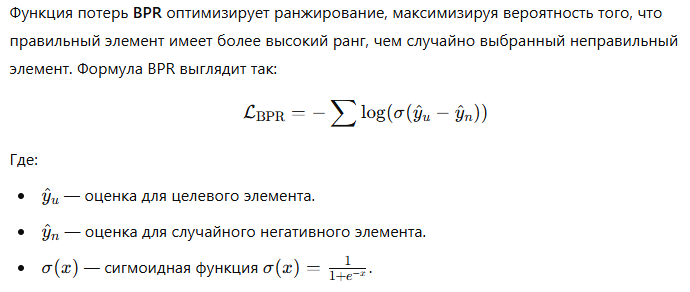

In [36]:
import torch

class BPRLoss(nn.Module):
    def __init__(self):
        super(BPRLoss, self).__init__()
    
    def forward(self, predictions, targets):
        """
        predictions: Tensor, логиты модели, размер [batch_size, num_items]
        targets: Tensor, индексы целевых элементов, размер [batch_size]
        """
        # Положительные предсказания (логиты целевых элементов)
        pos_preds = predictions[torch.arange(predictions.size(0)), targets]
        
        # Сэмплируем случайные отрицательные примеры
        neg_indices = torch.randint(0, predictions.size(1), size=(targets.size(0),), device=predictions.device)
        neg_preds = predictions[torch.arange(predictions.size(0)), neg_indices]
        
        # Разница между положительными и отрицательными предсказаниями
        diff = pos_preds - neg_preds
        
        # BPR Loss
        loss = -torch.log(torch.sigmoid(diff) + 1e-10).mean()
        return loss

# Инициализация модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRU4RecMovielens(num_movies=num_movies, embedding_size=embedding_size,
                         hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)

# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = BPRLoss()

# Обучение модели
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        input_seq = batch["input_seq"].to(device)
        target_movie = batch["target_movie"].to(device)
        
        # Прямой проход
        predictions = model(input_seq)
        loss = loss_function(predictions, target_movie.squeeze())
        
        # Обратный проход
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")

Epoch 1/10, Loss: 0.4331635243123791
Epoch 2/10, Loss: 0.310892778075271
Epoch 3/10, Loss: 0.22898138169522844
Epoch 4/10, Loss: 0.1781241727401072
Epoch 5/10, Loss: 0.15610907319009612
Epoch 6/10, Loss: 0.13836266340459566
Epoch 7/10, Loss: 0.1301337572000108
Epoch 8/10, Loss: 0.11603524963486347
Epoch 9/10, Loss: 0.11678803120180078
Epoch 10/10, Loss: 0.10817448478502409


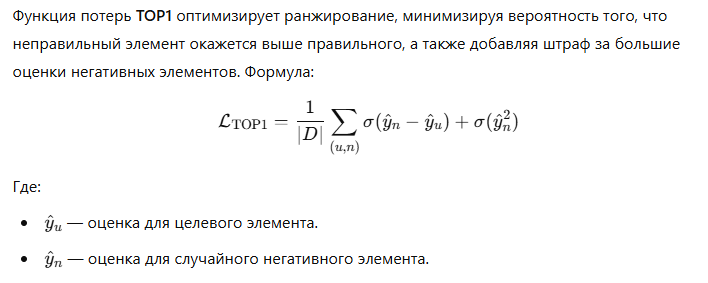

In [37]:
class TOP1Loss(nn.Module):
    def __init__(self):
        super(TOP1Loss, self).__init__()
    
    def forward(self, predictions, targets):
        """
        predictions: Tensor, логиты модели, размер [batch_size, num_items]
        targets: Tensor, индексы целевых элементов, размер [batch_size]
        """
        # Извлекаем логиты целевых элементов
        target_scores = predictions.gather(1, targets.unsqueeze(1))  # [batch_size, 1]
        
        # Вычисляем разницу между логитами целевых и всех остальных
        diff = target_scores - predictions  # [batch_size, num_items]
        
        # Логарифмическая вероятность
        loss_matrix = torch.sigmoid(diff)
        
        # TOP1 Loss: Среднее по всем парам
        loss = torch.mean(loss_matrix + 0.01 * predictions**2)
        return loss

In [38]:
# Инициализация модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRU4RecMovielens(num_movies=num_movies, embedding_size=embedding_size,
                         hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)

# Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = TOP1Loss()

# Обучение модели
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        input_seq = batch["input_seq"].to(device)
        target_movie = batch["target_movie"].to(device)
        
        # Прямой проход
        predictions = model(input_seq)
        loss = loss_function(predictions, target_movie.squeeze())
        
        # Обратный проход
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}")

Epoch 1/10, Loss: 0.26903172409496623
Epoch 2/10, Loss: 0.19431366519067836
Epoch 3/10, Loss: 0.14311598970132516
Epoch 4/10, Loss: 0.10864460040053787
Epoch 5/10, Loss: 0.09195358434877476
Epoch 6/10, Loss: 0.08320949965765059
Epoch 7/10, Loss: 0.07781805776174888
Epoch 8/10, Loss: 0.07415531431751467
Epoch 9/10, Loss: 0.07164155109499191
Epoch 10/10, Loss: 0.06957558693363523
